In [310]:
# imports for the random forest
import numpy as np
import scipy.stats as stats
import pandas as pd
import glob
import csv
import matplotlib.pyplot as plt


import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics


from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

In [328]:
## Load in full data set
# dateTime = 0 ', 'Kp= 1', 'Dst=2', 'dens=3', 'velo=4', 'Pdyn=5', 'ByIMF=6', 'BzIMF=7',
#        'mep06=8', 'mep05', 'mep01', 'me03', 'Lval', 'mlt', 'lat', 'lon'],
maxset = pd.read_csv("/content/csv_data/metop_rad_belt_passes_max.csv")
minset = pd.read_csv("/content/csv_data/metop_rad_belt_passes_min.csv") 
medset = pd.read_csv("/content/csv_data/metop_rad_belt_passes_median.csv") 

dataset=maxset
dataset.columns = ['maxdateTime', 'maxKp', 'maxDst', 'maxdens', 'maxvelo', 
                   'maxPdyn', 'maxByIMF', 'maxBzIMF', 'maxmep06', 'maxmep05', 
                   'maxmep01', 'maxme03', 'maxLval', 'maxmlt', 'maxlat', 
                   'maxlon']
dataset['MinBz'] = minset.BzIMF
dataset['MinBy'] = minset.ByIMF
dataset['medKp'] = medset.Kp
dataset['medDst'] = medset.Dst
dataset['meddens'] = medset.dens
dataset['medvelo'] = medset.velo
dataset['medPdyn'] = medset.Pdyn
dataset['medmep06'] = medset.mep06
dataset['maxmomentum'] = dataset.maxdens * dataset.maxvelo
dataset['medmomentum'] = dataset.meddens * dataset.medvelo

dropcolumns = ['maxdateTime', 'maxmep05', 'maxmep01', 'maxme03', 'maxLval', 
               'maxmlt', 'maxlat', 'maxlon']
dataset = dataset.drop(columns=dropcolumns)

# ['maxKp', 'maxDst', 'maxdens', 'maxvelo', 'maxPdyn', 'maxByIMF', 'maxBzIMF', 
#    'maxmep06', 'MinBz', 'MinBy', 'medKp', 'medDst', 'meddens', 
#    'medvelo', 'medPdyn', 'medmep06', 'maxmomentum', 'medmomentum']
 
#moredrops = [0,1,2]
#dataset = dataset.drop(columns = dataset.columns.values[moredrops])


In [322]:
# loading in the data and separating out the x and y
# and the train and test set 

shufval = 0    # set 1 to separate testing set through shuffling, 0 to window
testfrac = .8  # fraction of set to use for training
boolval = 0    # 0 for linear regression, 1 for boolean threshold
boolthresh = 1.0  # if boolean regression, set threshold of mep06 to count as an event
setlen = len(dataset)
trainmed = 1  # if 0, train on the max of mep06, if 1, train on the median instead
estimators = 1000  # number of estimators in random forest

if (shufval):
  train_dataset = dataset.sample(frac=testfrac,random_state=0)
  test_dataset = dataset.drop(train_dataset.index)
else:
  train_dataset = dataset[:round(testfrac*setlen)]
  test_dataset = dataset[round(testfrac*setlen):]

if (trainmed):
  y_train = train_dataset.pop('medmep06') 
  y_test = test_dataset.pop('medmep06')
  x_train = train_dataset.drop(columns = 'maxmep06')
  x_test = test_dataset.drop(columns = 'maxmep06')
else: 
  y_train = train_dataset.pop('maxmep06') 
  y_test = test_dataset.pop('maxmep06')
  x_train = train_dataset.drop(columns = 'medmep06')
  x_test = test_dataset.drop(columns = 'medmep06')

if (boolval):
  y_train = (y_train>boolthresh)*1
  y_test = (y_test>boolthresh)*1

regressor = RandomForestRegressor(n_estimators = estimators,  oob_score = True, random_state = 0) 
regressor.fit(x_train, y_train)  
Y_pred = regressor.predict(x_test)
if (boolval):
 Y_pred = (Y_pred>boolthresh)*1  
mae=metrics.mean_absolute_error(y_test, Y_pred)
mse=metrics.mean_squared_error(y_test, Y_pred)
trainsc = regressor.score(x_train, y_train) 
testsc = regressor.score(x_test, y_test)
regoob = regressor.oob_score_
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [323]:
## Evaluate performance
print("mean absolute error: %f;  mean squared error: %f" % (mae, mse))
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(regressor.score(x_train, y_train), 
                                                                                             regressor.oob_score_,
                                                                                             regressor.score(x_test, y_test)))

mean absolute error: 0.384973;  mean squared error: 0.265634
R^2 Training Score: 0.85 
OOB Score: -0.07 
R^2 Validation Score: -3.58


Feature ranking:
1. feature maxKp (0.123993)
2. feature maxDst (0.116868)
3. feature maxdens (0.114557)
4. feature maxvelo (0.109581)
5. feature maxPdyn (0.061769)
6. feature maxByIMF (0.058479)
7. feature maxBzIMF (0.057728)
8. feature MinBz (0.055760)
9. feature MinBy (0.048476)
10. feature medKp (0.048355)
11. feature medDst (0.043451)
12. feature meddens (0.039026)
13. feature medvelo (0.033950)
14. feature medPdyn (0.033004)
15. feature maxmomentum (0.029791)
16. feature medmomentum (0.025213)


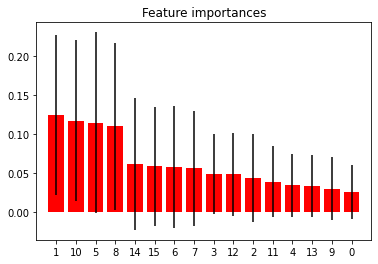

1738.9147615498555


In [324]:
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, x_test.columns.values[round(f)], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train.shape[1]), indices)
plt.xlim([-1, x_train.shape[1]])
plt.show()

In [315]:
# set up evaluation table
# parameters are [shufval, testfrac, boolval, boolthresh, setlen, trainmed, estimators]
params = np.array([shufval, testfrac, boolval, boolthresh, setlen, trainmed, estimators])
eval_table = pd.DataFrame([params,params])
eval_table.shape
eval_table.index = ['mae', 'mse']
eval_table.columns = ['shufval', 'testfrac', 'boolval', 'boolthresh', 'setlen', 'trainmed', 'estimators']
